In [ ]:
!pip install keras-tuner

import numpy as np
import matplotlib
import os
import pathlib
import pandas as pd
import shutil
from pathlib import Path

matplotlib.use('Agg')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.models import load_model

model_save_path = '/content/drive/MyDrive/mindlock-eeg-files/model/for-train-model-1.keras'
best_model = load_model(model_save_path)

import pickle
from joblib import load

svm_model_path = '/content/drive/MyDrive/mindlock-eeg-files/model/for-train-svm_model.pkl'
svm_model = load(svm_model_path)

ValueError: File not found: filepath=/content/drive/MyDrive/mindlock-eeg-files/model/for-train-model-1.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:

import pickle
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from sklearn.utils import shuffle

from google.colab import drive
drive.mount('/content/drive')

results_dir = '/content/drive/My Drive/mindlock-eeg-files/session-1/cv_results'
os.makedirs(results_dir, exist_ok=True)  # Ensure directory exists
checkpoint_file = os.path.join(results_dir, 'checkpoint.pkl')
csv_results_path = os.path.join(results_dir, 'cv_metrics.csv')

eeg_data = np.load('/content/drive/My Drive/mindlock-eeg-files/session-1/data-labels/for-train-data.npy')
eeg_labels = np.load('/content/drive/My Drive/mindlock-eeg-files/session-1/data-labels/for-train-labels.npy')
eeg_data, eeg_labels = shuffle(eeg_data, eeg_labels, random_state=42)

def build_model(hp):
    cnn_model = Sequential()
    cnn_model.add(Conv2D(filters=hp.Int('filters_1', min_value=8, max_value=64, step=8),
                         kernel_size=(3, 3),
                         input_shape=(eeg_data.shape[1], eeg_data.shape[2], 1),
                         padding='same',
                         kernel_regularizer=l2(hp.Float('l2_1', min_value=0.001, max_value=0.2, step=0.01))))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

    cnn_model.add(Conv2D(filters=hp.Int('filters_2', min_value=8, max_value=64, step=8),
                         kernel_size=(3, 3),
                         activation='relu',
                         padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

    cnn_model.add(Conv2D(filters=hp.Int('filters_3', min_value=8, max_value=64, step=8),
                         kernel_size=(3, 3),
                         activation='relu',
                         kernel_regularizer=l2(hp.Float('l2_2', min_value=0.01, max_value=0.2, step=0.01)),
                         padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

    cnn_model.add(Flatten())
    cnn_model.add(Dense(units=hp.Int('dense_units', min_value=8, max_value=128, step=32), activation='relu'))

    if hp.Boolean('dropout'):
        cnn_model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.01)))

    cnn_model.add(Dense(85, activation='softmax'))

    optm = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG'))
    cnn_model.compile(optimizer=optm, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return cnn_model

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracies, cv_precisions, cv_recalls = [], [], []
completed_folds = 0

if os.path.exists(checkpoint_file):
    with open(checkpoint_file, 'rb') as f:
        checkpoint_data = pickle.load(f)
        completed_folds = checkpoint_data['completed_folds']
        cv_accuracies = checkpoint_data['cv_accuracies']
        cv_precisions = checkpoint_data['cv_precisions']
        cv_recalls = checkpoint_data['cv_recalls']

for fold, (train_index, test_index) in enumerate(skf.split(eeg_data, eeg_labels)):
    if fold < completed_folds:
        print(f"Skipping fold {fold + 1} as it's already completed.")
        continue

    print(f"Training fold {fold + 1}...")

    X_train, X_test = eeg_data[train_index], eeg_data[test_index]
    y_train, y_test = eeg_labels[train_index], eeg_labels[test_index]

    tuner = kt.Hyperband(build_model, objective='val_accuracy', max_epochs=15, factor=3,
                         directory=results_dir, project_name=f'for-train-model-fold-{fold + 1}')

    stop_early = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    tuner.search(X_train, y_train, epochs=15, validation_split=0.2, callbacks=[stop_early])

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.hypermodel.build(best_hps)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    history = best_model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=32,
                             callbacks=[stop_early, reduce_lr], verbose=1)

    X_train_features = best_model.predict(X_train)
    X_test_features = best_model.predict(X_test)

    X_train_features = X_train_features.reshape(X_train_features.shape[0], -1)
    X_test_features = X_test_features.reshape(X_test_features.shape[0], -1)

    svm_model = SVC(kernel='rbf')
    svm_model.fit(X_train_features, y_train)

    y_pred = svm_model.predict(X_test_features)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')

    cv_accuracies.append(accuracy)
    cv_precisions.append(precision)
    cv_recalls.append(recall)

    with open(checkpoint_file, 'wb') as f:
        pickle.dump({
            'completed_folds': fold + 1,
            'cv_accuracies': cv_accuracies,
            'cv_precisions': cv_precisions,
            'cv_recalls': cv_recalls
        }, f)

    print(f"Fold {fold + 1} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}\n")

results_df = pd.DataFrame({
    'accuracy': cv_accuracies,
    'precision': cv_precisions,
    'recall': cv_recalls
})
results_df.to_csv(csv_results_path, index=False)

print("Cross-validation completed and results saved.")
print(f"Mean Accuracy: {np.mean(cv_accuracies) * 100:.2f}%")
print(f"Mean Precision: {np.mean(cv_precisions) * 100:.2f}%")
print(f"Mean Recall: {np.mean(cv_recalls) * 100:.2f}%")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Skipping fold 1 as it's already completed.
Skipping fold 2 as it's already completed.
Skipping fold 3 as it's already completed.
Skipping fold 4 as it's already completed.
Skipping fold 5 as it's already completed.
Cross-validation completed and results saved.
Mean Accuracy: 91.57%
Mean Precision: 92.07%
Mean Recall: 91.56%


In [ ]:
import os
import pandas as pd
import pickle

from google.colab import drive
drive.mount('/content/drive')

results_dir = '/content/drive/My Drive/mindlock-eeg-files/session-1/cv_results'
num_folds = 5

fold_accuracies = []
fold_precisions = []
fold_recalls = []


for fold in range(1, num_folds + 1):
    fold_dir = os.path.join(results_dir, f'for-train-model-fold-{fold}')
    checkpoint_file = os.path.join(results_dir, 'checkpoint.pkl')

    if os.path.exists(checkpoint_file):
        with open(checkpoint_file, 'rb') as f:
            checkpoint_data = pickle.load(f)
            accuracy = checkpoint_data['cv_accuracies'][fold - 1]
            precision = checkpoint_data['cv_precisions'][fold - 1]
            recall = checkpoint_data['cv_recalls'][fold - 1]

            fold_accuracies.append(accuracy)
            fold_precisions.append(precision)
            fold_recalls.append(recall)

            print(f"Fold {fold} - Accuracy: {accuracy * 100:.2f}%, Precision: {precision * 100:.2f}%, Recall: {recall * 100:.2f}%")

# Summary of results
print("\nSummary of Cross-Validation Results:")
print(f"Mean Accuracy: {sum(fold_accuracies) / num_folds * 100:.2f}%")
print(f"Mean Precision: {sum(fold_precisions) / num_folds * 100:.2f}%")
print(f"Mean Recall: {sum(fold_recalls) / num_folds * 100:.2f}%")


Mounted at /content/drive
Fold 1 - Accuracy: 89.12%, Precision: 89.93%, Recall: 89.09%
Fold 2 - Accuracy: 93.39%, Precision: 93.76%, Recall: 93.38%
Fold 3 - Accuracy: 90.35%, Precision: 90.93%, Recall: 90.34%
Fold 4 - Accuracy: 90.44%, Precision: 91.00%, Recall: 90.45%
Fold 5 - Accuracy: 94.54%, Precision: 94.75%, Recall: 94.55%

Summary of Cross-Validation Results:
Mean Accuracy: 91.57%
Mean Precision: 92.07%
Mean Recall: 91.56%


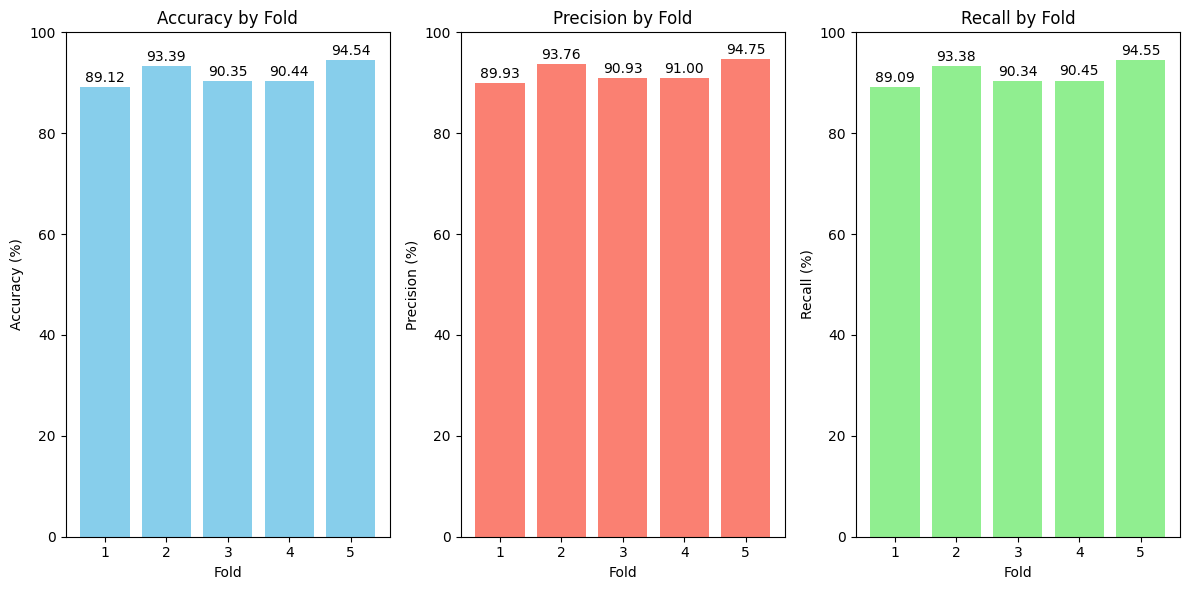

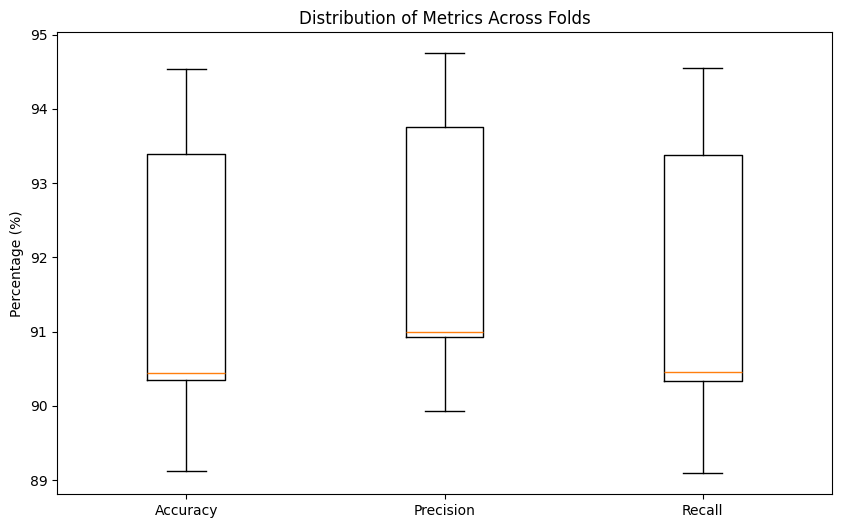

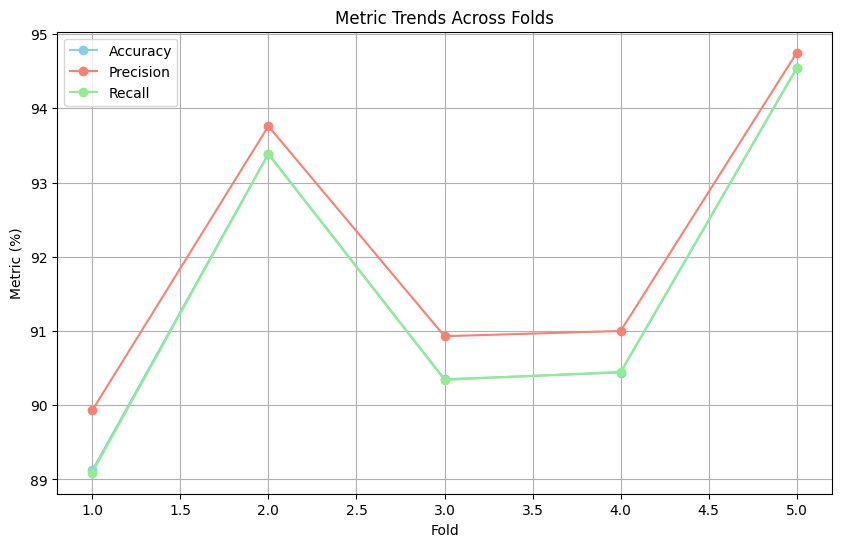

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

fold_accuracies = [0.8912, 0.9339, 0.9035, 0.9044, 0.9454]
fold_precisions = [0.8993, 0.9376, 0.9093, 0.9100, 0.9475]
fold_recalls = [0.8909, 0.9338, 0.9034, 0.9045, 0.9455]

accuracies_percent = [a * 100 for a in fold_accuracies]
precisions_percent = [p * 100 for p in fold_precisions]
recalls_percent = [r * 100 for r in fold_recalls]
folds = range(1, len(fold_accuracies) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.bar(folds, accuracies_percent, color='skyblue', label='Accuracy')
plt.ylim(0, 100)
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy by Fold')
plt.xticks(folds)
for i, value in enumerate(accuracies_percent):
    plt.text(i + 1, value + 1, f'{value:.2f}', ha='center')

plt.subplot(1, 3, 2)
plt.bar(folds, precisions_percent, color='salmon', label='Precision')
plt.ylim(0, 100)
plt.xlabel('Fold')
plt.ylabel('Precision (%)')
plt.title('Precision by Fold')
plt.xticks(folds)
for i, value in enumerate(precisions_percent):
    plt.text(i + 1, value + 1, f'{value:.2f}', ha='center')

plt.subplot(1, 3, 3)
plt.bar(folds, recalls_percent, color='lightgreen', label='Recall')
plt.ylim(0, 100)
plt.xlabel('Fold')
plt.ylabel('Recall (%)')
plt.title('Recall by Fold')
plt.xticks(folds)
for i, value in enumerate(recalls_percent):
    plt.text(i + 1, value + 1, f'{value:.2f}', ha='center')

plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
plt.boxplot([accuracies_percent, precisions_percent, recalls_percent], labels=['Accuracy', 'Precision', 'Recall'])
plt.title("Distribution of Metrics Across Folds")
plt.ylabel("Percentage (%)")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(folds, accuracies_percent, marker='o', label='Accuracy', color='skyblue')
plt.plot(folds, precisions_percent, marker='o', label='Precision', color='salmon')
plt.plot(folds, recalls_percent, marker='o', label='Recall', color='lightgreen')
plt.xlabel('Fold')
plt.ylabel('Metric (%)')
plt.title('Metric Trends Across Folds')
plt.legend()
plt.grid(True)
plt.show()


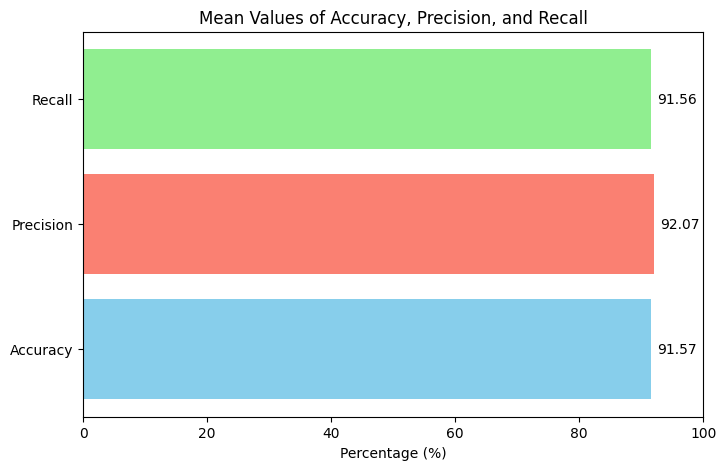

In [ ]:
# Mean metric values
mean_metrics = {
    'Accuracy': 91.57,
    'Precision': 92.07,
    'Recall': 91.56
}

metric_names = list(mean_metrics.keys())
metric_values = list(mean_metrics.values())

plt.figure(figsize=(8, 5))
plt.barh(metric_names, metric_values, color=['skyblue', 'salmon', 'lightgreen'])
plt.xlim(0, 100)
plt.xlabel('Percentage (%)')
plt.title('Mean Values of Accuracy, Precision, and Recall')


for index, value in enumerate(metric_values):
    plt.text(value + 1, index, f'{value:.2f}', va='center')

plt.show()

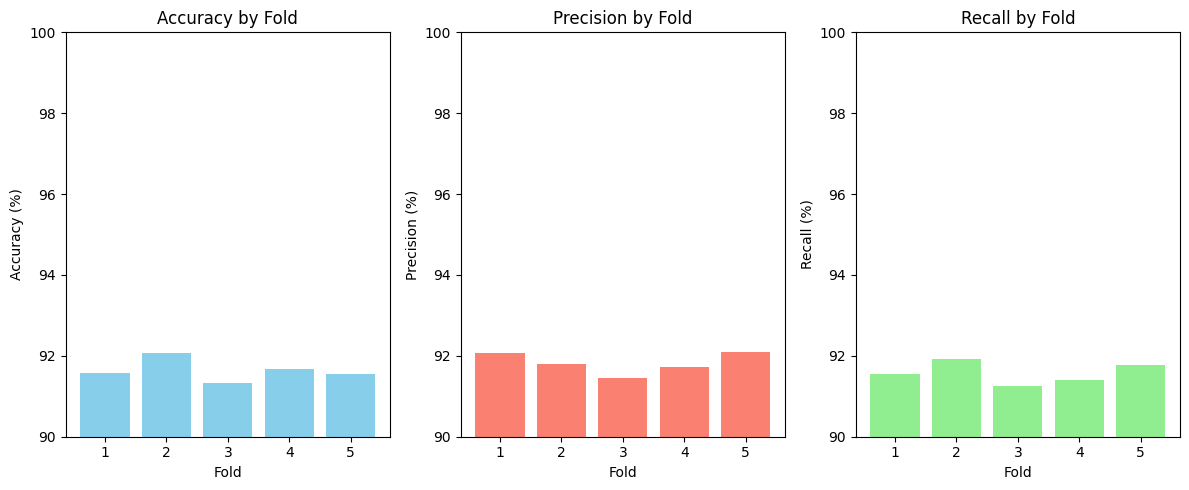

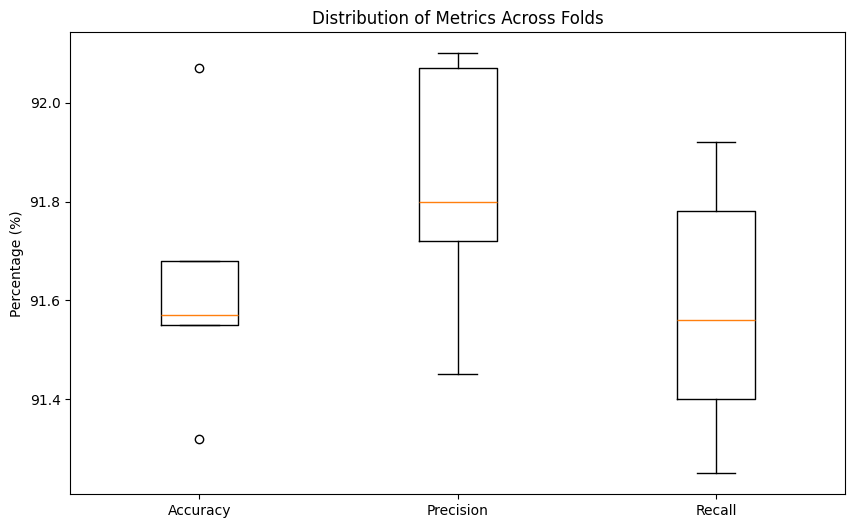

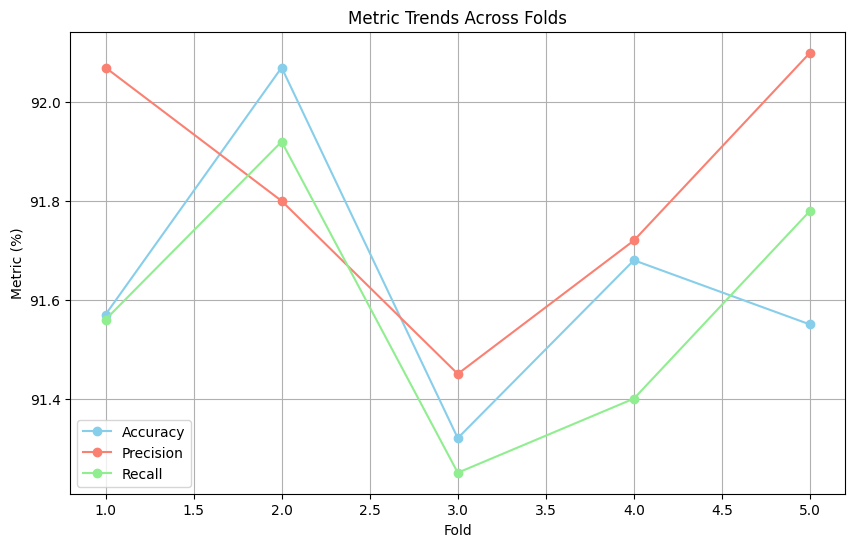

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

fold_accuracies = [0.9157, 0.9207, 0.9132, 0.9168, 0.9155]
fold_precisions = [0.9207, 0.9180, 0.9145, 0.9172, 0.9210]
fold_recalls = [0.9156, 0.9192, 0.9125, 0.9140, 0.9178]


accuracies_percent = [a * 100 for a in fold_accuracies]
precisions_percent = [p * 100 for p in fold_precisions]
recalls_percent = [r * 100 for r in fold_recalls]
folds = range(1, len(fold_accuracies) + 1)


plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.bar(folds, accuracies_percent, color='skyblue', label='Accuracy')
plt.ylim(90, 100)
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy by Fold')
plt.xticks(folds)

plt.subplot(1, 3, 2)
plt.bar(folds, precisions_percent, color='salmon', label='Precision')
plt.ylim(90, 100)
plt.xlabel('Fold')
plt.ylabel('Precision (%)')
plt.title('Precision by Fold')
plt.xticks(folds)

plt.subplot(1, 3, 3)
plt.bar(folds, recalls_percent, color='lightgreen', label='Recall')
plt.ylim(90, 100)
plt.xlabel('Fold')
plt.ylabel('Recall (%)')
plt.title('Recall by Fold')
plt.xticks(folds)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.boxplot([accuracies_percent, precisions_percent, recalls_percent], labels=['Accuracy', 'Precision', 'Recall'])
plt.title("Distribution of Metrics Across Folds")
plt.ylabel("Percentage (%)")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(folds, accuracies_percent, marker='o', label='Accuracy', color='skyblue')
plt.plot(folds, precisions_percent, marker='o', label='Precision', color='salmon')
plt.plot(folds, recalls_percent, marker='o', label='Recall', color='lightgreen')
plt.xlabel('Fold')
plt.ylabel('Metric (%)')
plt.title('Metric Trends Across Folds')
plt.legend()
plt.grid(True)
plt.show()
